In [340]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
# from kernels.squared_exponential import SquaredExponential
# from kernels.matern import Matern
from torch.optim import Adam

# import sys
import math
# sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/Tests and Sanity Checks/')
from efgpnd import EFGPND
import warnings
# warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# Generating some synthetic data

In [341]:


# --- Parameters ---
n = 100  # Number of points
d = 1  # Dimensionality of the input space
true_length_scale =0.25
true_variance = 1
true_noise_variance = (0.05)**2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1
x, _ = torch.sort(x, dim=0)

Using device: cpu


In [342]:
# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 20
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

In [343]:
from vanilla_gp_sampling import sample_gp_fast, sample_gp_matern

# # For squared exponential kernel
samples_se = sample_gp_fast(
    x,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
)
# # For Matern kernel
# samples_m32 = sample_gp_matern(
#     x,
#     nu=1.5,  # 3/2 Matern
#     length_scale=true_length_scale,
#     variance=true_variance,
#     noise_variance=true_noise_variance
# )
y = samples_se

# remove samples from the middle
inds_to_keep = np.concatenate([np.arange(n//2 - 5), np.arange(n //2 + 5, n)])
x = x[inds_to_keep]
y = y[inds_to_keep]
n = torch.numel(x)

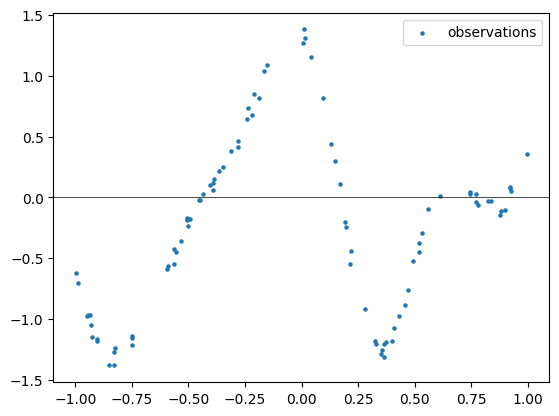

In [344]:
plt.scatter(x, y, s=5, label='observations')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.show()

# Using EFGPND 

In [345]:
d = 1
EPSILON = 1e-4 # bound on kernel error 
cg_tol = EPSILON 

## Hyperparameter learning
    Note that compute_gradients by default puts the grads in model._gp_params.hyper.rawgrad so that optimizer can use them.

In [346]:
max_iters = 200
J = 5
## hyper learning with Adam
model = EFGPND(x, y, kernel="SquaredExponential", eps=EPSILON)
# params = next(model.parameters())

optimizer = Adam(model.parameters(), lr=0.1)
for it in range(max_iters):
    optimizer.zero_grad()
     # saves grads in model._gp_params so that we can step 
    model.compute_gradients(
                trace_samples=J,
                cg_tol = EPSILON / 10
            )
    # model.compute_gradients(trace_samples=10,cg_tol = 1e-10)
    
    optimizer.step() 
    
    if it % 10 == 0:
        lengthscale = model.kernel.get_hyper('lengthscale')
        variance = model.kernel.get_hyper('variance')
        sigmasq = model._gp_params.sig2.item()
        # Get current values for printing
        print(f"[ε={EPSILON} | J={J}] iter {it:>3}  "
            f"ℓ={lengthscale:.4g}  "
            f"σ_f²={variance:.4g}  σ_n²={sigmasq:.4g}")

print(f'Final hyperparams: ℓ={lengthscale:.4g}, σ_f²={variance:.4g}, σ_n²={sigmasq:.4g}')

# Get specific gradients
# lengthscale_gradient = model.kernel.lengthscale_param.grad
# variance_gradient = model.kernel.variance_param.grad  
# noise_gradient = model._gp_params.sig2.grad

# print(f'Final lengthscale gradient: {lengthscale_gradient}')
# print(f'Final variance gradient: {variance_gradient}')
# print(f'Final noise gradient: {noise_gradient}')

[ε=0.0001 | J=5] iter   0  ℓ=0.2714  σ_f²=0.5749  σ_n²=0.004707
[ε=0.0001 | J=5] iter  10  ℓ=0.175  σ_f²=0.9294  σ_n²=0.001964
[ε=0.0001 | J=5] iter  20  ℓ=0.181  σ_f²=0.7875  σ_n²=0.00217
[ε=0.0001 | J=5] iter  30  ℓ=0.2074  σ_f²=0.588  σ_n²=0.002587
[ε=0.0001 | J=5] iter  40  ℓ=0.2185  σ_f²=0.5834  σ_n²=0.002249
[ε=0.0001 | J=5] iter  50  ℓ=0.2073  σ_f²=0.7017  σ_n²=0.002338
[ε=0.0001 | J=5] iter  60  ℓ=0.2096  σ_f²=0.7507  σ_n²=0.002322
[ε=0.0001 | J=5] iter  70  ℓ=0.2116  σ_f²=0.7431  σ_n²=0.002292
[ε=0.0001 | J=5] iter  80  ℓ=0.2094  σ_f²=0.7517  σ_n²=0.002326
[ε=0.0001 | J=5] iter  90  ℓ=0.2171  σ_f²=0.7139  σ_n²=0.002342
[ε=0.0001 | J=5] iter 100  ℓ=0.2094  σ_f²=0.7671  σ_n²=0.002282
[ε=0.0001 | J=5] iter 110  ℓ=0.221  σ_f²=0.7769  σ_n²=0.002324
[ε=0.0001 | J=5] iter 120  ℓ=0.2107  σ_f²=0.8432  σ_n²=0.002312
[ε=0.0001 | J=5] iter 130  ℓ=0.2155  σ_f²=0.7776  σ_n²=0.002282
[ε=0.0001 | J=5] iter 140  ℓ=0.2177  σ_f²=0.7476  σ_n²=0.002395
[ε=0.0001 | J=5] iter 150  ℓ=0.2097  σ_f²=0.7

### Compare learned hyperparameters to hyperparameters that generated data

In [347]:
l_err = (lengthscale - true_length_scale) / true_length_scale
print(f'lengthscale relative error: {l_err:0.2f}')
v_err = (variance - true_variance) / true_variance
print(f'variance relative error: {v_err:0.2f}')
s_err = (sigmasq - true_noise_variance) / true_noise_variance
print(f'observation noise relative error: {s_err:0.2f}')

lengthscale relative error: -0.15
variance relative error: -0.30
observation noise relative error: -0.06


## Fitting posterior mean

In [348]:
# Time different variance estimation methods
import time

# No variance
start_time = time.time()
mean_no_var, _= model.predict(x_new, return_variance=False)
no_var_time = time.time() - start_time
print(f"Time without variance: {no_var_time:.4f} seconds; x_new.shape = {x_new.shape}")


Time without variance: 0.0158 seconds; x_new.shape = torch.Size([3000, 1])


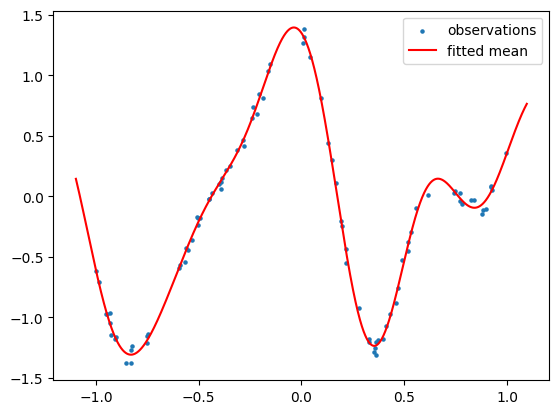

In [349]:
plt.scatter(x, y, s=5, label='observations')
plt.plot(x_new, mean_no_var, color='red', label='fitted mean')
plt.legend()
plt.show()

## Posterior variance -- Stochastic Estimate

In [350]:
start_time = time.time()
hutchinson_probes = 1000
mean, stoch_var = model.predict(x_new, return_variance=True, variance_method="stochastic", hutchinson_probes=hutchinson_probes)
stoch_var_time = time.time() - start_time
print(f"Time with stochastic variance, x_new.shape = {x_new.shape}, {hutchinson_probes} probes: {stoch_var_time:.4f} seconds")

Time with stochastic variance, x_new.shape = torch.Size([3000, 1]), 1000 probes: 0.0527 seconds


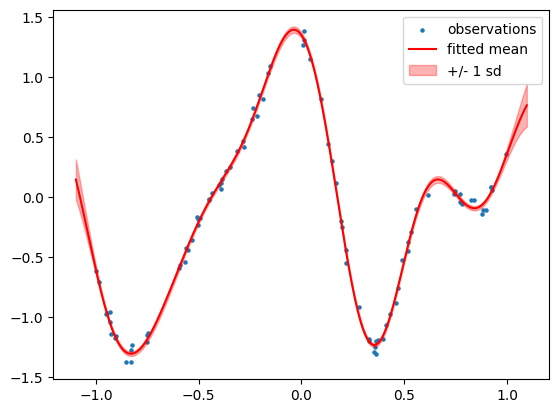

In [351]:
plt.scatter(x, y, s=5, label='observations')
plt.plot(x_new, mean_no_var, color='red', label='fitted mean')

# Add +/- 1sd
stoch_sd = torch.sqrt(stoch_var)
plt.fill_between(x_new.ravel(), mean_no_var - stoch_sd, mean_no_var + stoch_sd, 
                 alpha=0.3, color='red', label='+/- 1 sd')

plt.legend()
plt.show()

## Posterior variance -- regular method

In [352]:
# Regular variance
start_time = time.time()
mean, var = model.predict(x_new, return_variance=True, variance_method="regular")
reg_var_time = time.time() - start_time
print(f"Time with regular variance, x_new.shape = {x_new.shape}: {reg_var_time:.4f} seconds")

Time with regular variance, x_new.shape = torch.Size([3000, 1]): 0.0987 seconds


Maybe update idea- Context variables instead of all the opts 
- with .... settings = exact... 

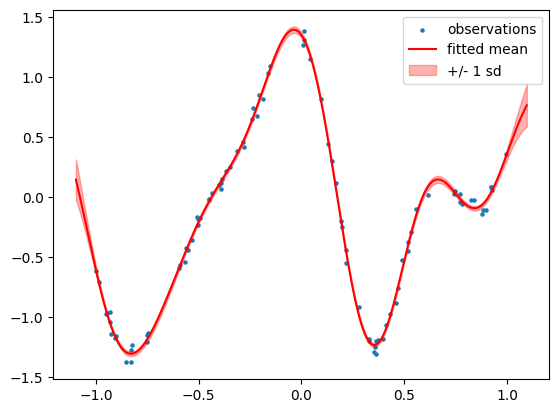

In [353]:
sd = torch.sqrt(var)
plt.scatter(x, y, s=5, label='observations')
plt.plot(x_new, mean_no_var, color='red', label='fitted mean')

# Add confidence bands
plt.fill_between(x_new.ravel(), mean_no_var - sd, mean_no_var + sd, 
                 alpha=0.3, color='red', label='+/- 1 sd')

plt.legend()
plt.show()

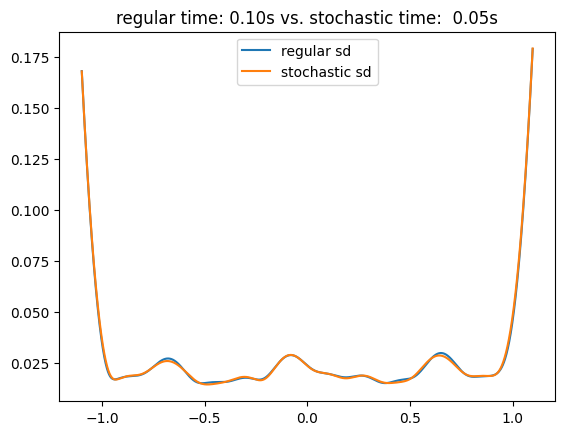

In [354]:
plt.plot(x_new, sd, label='regular sd')
plt.plot(x_new, stoch_sd, label='stochastic sd')
plt.legend()
plt.title(f'regular time: {reg_var_time:.2f}s vs. stochastic time: {stoch_var_time: .2f}s')
plt.show()